In [45]:
import fastbox as fb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm 

In [2]:
import warnings
from ruamel.yaml.error import UnsafeLoaderWarning

# 忽略UnsafeLoaderWarning
warnings.simplefilter('ignore', UnsafeLoaderWarning)

# Liquidily of options

1、Trading volume relationship between options and underlying futures

In [3]:
id_lst = [ f'CU230{i+1}' for i in range(12)]
# 先研究id_lst[0]
CU2301_options = fb.data.futuresoptions.daily(instrumentid = id_lst[0])
CU2301_futures = fb.data.futures.daily(instrumentid = id_lst[0])
CU2301_options_vol = CU2301_options['vol'].groupby(level = 'date').sum()
# may exist some 
CU2301_options_vol.index=(CU2301_futures.delist_date.iloc[0]-CU2301_options_vol.index).days+1
CU2301_options_vol.name =  f'{id_lst[0]} options'
index0 = CU2301_options_vol.index.min()
CU2301_futures_vol = CU2301_futures.loc[:,'vol']
CU2301_futures_vol.name =  f'{id_lst[0]} futures' 
CU2301_futures_vol.index=(CU2301_futures.delist_date.iloc[0]-CU2301_futures_vol.index).days+1
CU2301_vol=pd.concat([CU2301_futures_vol,CU2301_options_vol],axis=1).sort_index()
CU2301_vol.loc[0,:]=0
CU2301_vol = CU2301_vol.sort_index().fillna(0)

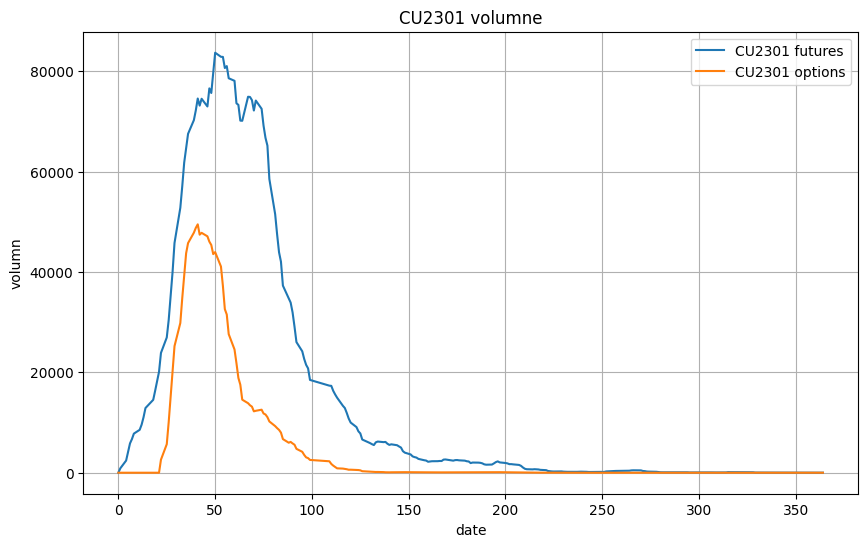

In [4]:
plt.figure(figsize=(10, 6))
smoothed = CU2301_vol.rolling(window=10,min_periods=0).mean()
plt.plot(smoothed, label=smoothed.columns)
plt.title("CU2301 volumne")
plt.xlabel('date')
plt.ylabel('volumn')

plt.legend()

plt.grid(True)

plt.show()

2、i want to get $\tau_1$ and $\tau_2$ (about a month),and the trading volume of options and futures accounts for the highest proportion of the total trading volume between $\tau_1$ and $\tau_2$

In [49]:
class total_liquid(object):
    def __init__(self,name):
        self.name = name

    def get_vol_data(self):
        _name = self.name
        options = fb.data.futuresoptions.daily(instrumentid = name)
        futures = fb.data.futures.daily(instrumentid = name)
        if options is None or futures is None:
            print('No data')
            return None
        else:
            options_vol = options['vol'].groupby(level = 'date').sum()
            options_vol.index=(futures.delist_date.iloc[0]-options_vol.index).days+1
            options_vol.name =  f'{_name} options'
            futures_vol = futures.loc[:,'vol']
            futures_vol.name =  f'{_name} futures' 
            futures_vol.index=(futures.delist_date.iloc[0]-futures_vol.index).days+1
            vol=pd.concat([futures_vol,options_vol],axis=1).sort_index()
            vol.loc[0,:]=0
            vol = vol.sort_index().fillna(0)     
            return vol
    def plot_one(self):
        _vol = self.get_vol_data()
        if _vol is None:
            pass
        else:
            plt.figure(figsize=(10, 6))
            smoothed = _vol.rolling(window=10,min_periods=0).mean()
            plt.plot(smoothed, label=smoothed.columns)
            plt.title(f"{self.name} volumne")
            plt.xlabel('date')
            plt.ylabel('volumn')
            plt.legend()
            plt.grid(True)
            plt.show()
    def plot_two(self):
        _vol = self.get_vol_data()
        _tau_lst,_propor = self.get_tau_two()
        if _vol is None:
            pass
        else:
            _tau1=_tau_lst[0]
            _tau2=_tau_lst[-1]
            smoothed = _vol.rolling(window=10,min_periods=0).mean()
            _min_vol = smoothed.min(axis=1)
            y = _min_vol.values
            x = np.array(_min_vol.index)

            plt.figure(figsize=(10, 6))
            plt.plot(smoothed, label=smoothed.columns)
            plt.fill_between(x, y, where=(x >= _tau1) & (x <= _tau2), color='gray', alpha=0.5)
            plt.title(f"{self.name} volumne")
            plt.xlabel('date')
            plt.ylabel('volumn')
            plt.legend()
            plt.grid(True)
            plt.show()   
            print(f'proportion:{_propor}')
    def get_tau_one(self):
        # in this way,i will let min(vol_option,vol_fulture) get the largest proportion between tau1 and tau2
        _vol = self.get_vol_data()
        if _vol is None:
            pass
        else:
            tau2 = _vol.min(axis=1).rolling(window=30,min_periods=1).sum().idxmax()
            propor = (_vol.rolling(window=30,min_periods=1).sum().loc[tau2,:]/_vol.sum()).mean()
            tau_lst = _vol.loc[:tau2][-30:].index.tolist()
            tau1 = tau_lst[0]
            return tau_lst,propor
    def get_tau_two(self):
        # in this way,i will let min(vol_option,vol_fulture) get the largest proportion between tau1 and tau2
        _vol = self.get_vol_data()
        if _vol is None:
            pass
        else:
            tau2 = (_vol.rolling(window=30,min_periods=1).sum()/_vol.sum()).sum(axis=1).idxmax()
            propor = (_vol.rolling(window=30,min_periods=1).sum().loc[tau2,:]/_vol.sum()).mean()
            tau_lst = _vol.loc[:tau2][-30:].index.tolist()
            tau1 = tau_lst[0]
        return tau_lst,propor
    def get_date(self):
        _tau_lst , _ = self.get_tau_two()
        _futures = fb.data.futures.daily(instrumentid = name)
        date_lst = []
        for i in _tau_lst:
            date_i = pd.Timedelta(days=(i-1))
            trade_date = _futures.delist_date.iloc[0] - date_i
            date_lst.append(trade_date.strftime('%Y-%m-%d'))
        return date_lst

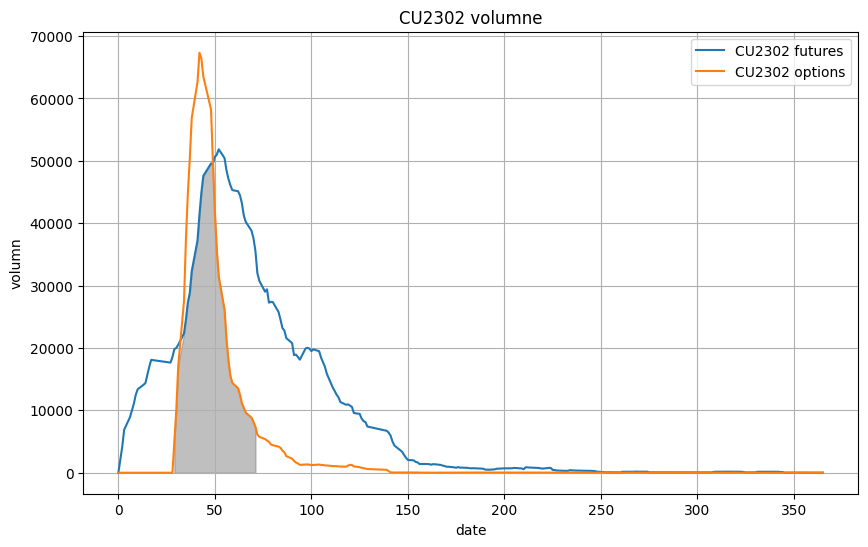

proportion:0.7486608207464367


In [34]:
name = id_lst[1]
liquid = total_liquid(name)
liquid.plot_two()

3.then, for the different options of the same fulture in one day,for put and cut options with different strike price,are traded with different price and different volume.i will compute the volatility of these options in effective dates.

In [50]:
name = id_lst[1]
liquid = total_liquid(name)
tau_lst , _ = liquid.get_tau_two()
date_lst = liquid.get_date()

In [51]:
from scipy.stats import norm
N = norm.cdf

def BS(forward, strike, mat, r, sigma, flag):
    sign = 1
    tau = mat / 360
    discount = np.exp(- r * tau)
    if flag == "P":
        sign = -1
    std_dev = sigma * np.sqrt(tau)

    d1 = np.log(forward/strike) / std_dev + 0.5 * std_dev
    d2 = d1 - std_dev
    result = discount * sign * (forward * N(sign * d1) - strike * N(sign * d2))
    return result

def IV(forward, strike, mat, r, price, flag):
    tau = mat / 360
    discount = np.exp(- r * tau)
    def root_func(x):
        return BS(forward, strike, mat, r, x, flag) - price
    sigma = newton(root_func, 0.2)
    return sigma

In [116]:
from scipy.optimize import newton
# i only calculate the volatility of in-the-money options
r=0.02
futures = fb.data.futures.daily(instrumentid = name)
all_result = []
for date in tqdm(date_lst):
    options = fb.data.futuresoptions.daily(instrumentid = name,from_date = date,to_date = date)
    options['weight']=options['vol']/options['vol'].groupby(level= 'call_put').sum()
    forward = futures.loc[date,'settle']
    future_volume = futures.loc[date,'vol']
    maturity = options.index.get_level_values('maturity')[0]
    mat=(maturity - options.index.get_level_values('date')[0]).days    
    for index in options.index:
        flag=index[2]
        strike=index[3]#strike price
        price=options.loc[index,'settle']#Option price     
        option_volume = options.loc[index,'vol']
        weight = options.loc[index,'weight'] 
        if (flag == 'C' and strike < forward) or (flag == 'P' and strike >= forward):
            try:
                volatility=IV(forward, strike, mat, r, price, flag)
                day_result = [date,maturity,flag,forward,strike,price,volatility,option_volume,future_volume,weight,mat]
                all_result.append(day_result)
            except:
                pass
volatility_one = pd.DataFrame(all_result,columns = ['trade_date','maturity','flag','forward','strike','price','volatility','option_volume','future_volume','weight','mat'])
volatility_one = volatility_one.set_index(['trade_date','maturity','mat','future_volume','forward','flag','strike'])

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]C:\Users\Administrator\AppData\Local\Temp\ipykernel_16844\3960409835.py:12: RuntimeWarning:

divide by zero encountered in scalar divide

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.68it/s]


In [117]:
volatility_one

price  \
trade_date maturity   mat future_volume forward flag strike            
2023-01-17 2023-01-18 1   23068.0       68450.0 C    64000.0  4450.0   
                                                     66000.0  2452.0   
                                                     67000.0  1490.0   
                                                     68000.0   686.0   
                                                P    69000.0   758.0   
...                                                              ...   
2022-12-07 2023-01-18 42  30537.0       65860.0 P    70000.0  4728.0   
                                                     71000.0  5554.0   
                                                     72000.0  6426.0   
                                                     73000.0  7330.0   
                                                     74000.0  8262.0   

                                                              volatility  \
trade_date maturity   mat future_volume forward flag strike                
2023-01-17 2023-01-18 1   23068.0       68450.0 C    64000.0    0.397307   
                                                     66000.0    0.279320   
                                                     67000.0    0.294065   
                                                     68000.0    0.295264   
                                                P    69000.0    0.296194   
...                                                                  ...   
2022-12-07 2023-01-18 42  30537.0       65860.0 P    70000.0    0.219713   
                                                     71000.0    0.219840   
                                                     72000.0    0.220543   
                                                     73000.0    0.220829   
                                                     74000.0    0.221589   

                                                              option_volume  \
trade_date maturity   mat future_volume forward flag strike                   
2023-01-17 2023-01-18 1   23068.0       68450.0 C    64000.0           47.0   
                                                     66000.0          253.0   
                                                     67000.0          237.0   
                                                     68000.0         1471.0   
                                                P    69000.0         1168.0   
...                                                                     ...   
2022-12-07 2023-01-18 42  30537.0       65860.0 P    70000.0           11.0   
                                                     71000.0            5.0   
                                                     72000.0            2.0   
                                                     73000.0           13.0   
                                                     74000.0            0.0   

                                                                weight  
trade_date maturity   mat future_volume forward flag strike             
2023-01-17 2023-01-18 1   23068.0       68450.0 C    64000.0  0.001936  
                                                     66000.0  0.010419  
                                                     67000.0  0.009760  
                                                     68000.0  0.060577  
                                                P    69000.0  0.044294  
...                                                                ...  
2022-12-07 2023-01-18 42  30537.0       65860.0 P    70000.0  0.003003  
                                                     71000.0  0.001365  
                                                     72000.0  0.000546  
                                                     73000.0  0.003549  
                                                     74000.0  0.000000  

[697 rows x 4 columns]

4、then i will calibrate the volatility through sabr model.In this step, I would give greater weight to options with greater trading volume

In [107]:
class sabr(object):
    def __init__(self, alpha, beta, rho, volvol):
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.volvol = volvol
        
    def lognormal_vol(self, k, f, t):
        alpha, beta, rho, volvol = self.alpha ,self.beta ,self.rho ,self.volvol
        # Negative strikes or forwards
        if k <= 0 or f <= 0:
            return 0.
        eps = 1e-07
        logfk = np.log(f / k)
        fkbeta = (f*k)**(1 - beta)
        a = (1 - beta)**2 * alpha**2 / (24 * fkbeta)
        b = 0.25 * rho * beta * volvol * alpha / fkbeta**0.5
        c = (2 - 3*rho**2) * volvol**2 / 24
        d = fkbeta**0.5
        v = (1 - beta)**2 * logfk**2 / 24
        w = (1 - beta)**4 * logfk**4 / 1920
        z = volvol * fkbeta**0.5 * logfk / alpha
        if abs(z) > eps:
            vz = alpha * z * (1 + (a + b + c) * t) / (d * (1 + v + w) * self._x(z))
            return vz
        # ATM
        else:
            v0 = alpha * (1 + (a + b + c) * t) / (d * (1 + v + w))
            return v0

    def _x(self, z):
        rho = self.rho
        a = (1 - 2*rho*z + z**2)**.5 + z - rho
        b = 1 - rho
        return np.log(a / b)

In [128]:
initial_guess = [0.01, 0.00, 0.10, 0.5]
x0 = np.array(initial_guess)
bounds = [(0.0001, 2), (-0.9999, 0.9999), (0.0001, 2), (0.0001, 2)]

In [132]:
from scipy.optimize import minimize
dates = np.unique(volatility_one.index.get_level_values('trade_date'))
result_all = []
for date in tqdm(dates):
    volatility_day = volatility_one.loc[(volatility_one.index.get_level_values('trade_date') == date), :]
    strikes = volatility_day.index.get_level_values('strike')
    forward = volatility_day.index.get_level_values('forward')[0]
    mat = volatility_day.index.get_level_values('mat')[0]
    weight = volatility_day.loc[:,'weight'].values
    vols_BS = volatility_day.loc[:,'volatility'].values
    
    def vol_square_error(x):
        sabr0 = sabr(x[0], x[1], x[2], x[3])
        vols = np.array([sabr0.lognormal_vol(k_, forward, mat / 360)*100 for k_ in strikes])
        return sum(((vols - vols_BS)*weight)**2)
    
    res = minimize(vol_square_error, x0, method='L-BFGS-B', bounds=bounds)
    alpha, beta, rho, volvol = res.x
    success = res.success
    resid = res.fun
    result_date = [alpha, beta, rho, volvol,success,resid]
    result_all.append(result_date)
sabr_para = pd.DataFrame(result_all,columns = ['alpha', 'beta', 'rho', 'volvol','success','resid'],index = dates)

  0%|                                                                                           | 0/29 [00:00<?, ?it/s]C:\Users\Administrator\AppData\Local\Temp\ipykernel_16844\3538839679.py:35: RuntimeWarning:

invalid value encountered in log

C:\Users\Administrator\AppData\Local\Temp\ipykernel_16844\3538839679.py:33: RuntimeWarning:

invalid value encountered in scalar power

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 37.44it/s]


In [133]:
sabr_para

,alpha,beta,rho,volvol,success,resid
2022-12-07,0.010000,1.491841e-05,0.100392,0.500001,True,6.496361e-05
2022-12-08,0.010000,4.025781e-09,0.100000,0.500000,True,1.864442e-04
2022-12-09,0.009761,-3.436549e-05,0.099758,0.499905,True,1.164008e-04
2022-12-12,0.205895,5.956177e-01,0.202958,0.006612,True,9.575167e-10
2022-12-13,0.152455,6.217102e-01,0.705958,0.001136,True,7.897935e-10
2022-12-14,0.192591,5.987134e-01,0.144284,0.005228,True,3.761229e-10
2022-12-15,0.448992,5.169983e-01,0.489325,0.000100,True,9.246544e-10
2022-12-16,0.010000,-1.366157e-14,0.100000,0.500000,True,5.519105e-05
2022-12-19,0.141650,6.208862e-01,0.154526,0.019693,True,1.622580e-08
2022-12-20,1.046901,4.403890e-01,0.245212,0.008613,True,3.802047e-09


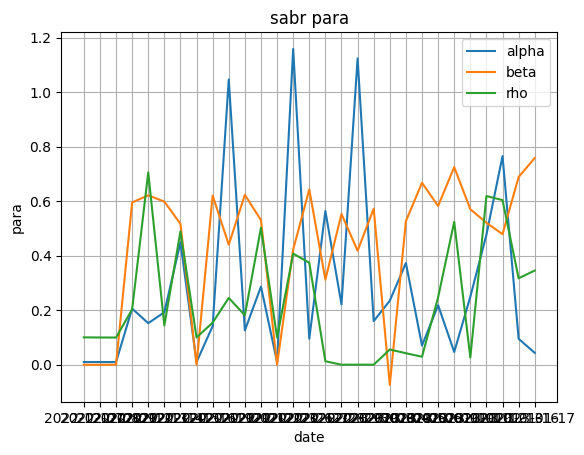

In [134]:
plt.xlabel('date') 
plt.ylabel('para') 
plt.title("sabr para")
plt.plot(sabr_para.iloc[:,:3], label=sabr_para.iloc[:,:3].columns)
plt.grid(True)  
plt.legend()
plt.show()